# Lithography Simulation with Python - Notebook

In this notebook we present some insights about the simulation of the **lithographic process**. This document is not intended to provide a complete description of the mechanisms at stake when dealing with lithography but rather give some elements about what's going on and how to simulate it. 
<img src="img/intro_image.png" width="750" />
<h3 align="center">Some illustrations of what we will achieve at the end of this notebook.</h3>

Complete description of lithography simulation can be found in numerous textbooks (see <i>References</i> below) but numerical implementation is usually not describe thoroughly. The Jupyter NoteBook is a perfect support to share the numerical aspects relative to the simulation of lithography. We will limit our development to scalar models for imaging, valid for numerical aperture up to 0.5 ~ 0.6. Such models are not suited to cutting edge lithography equipments, though they are of paramount importance to understand more complex systems. With time, the vectorial aspect of light could be added/discussed within the framework of this notebook.

For it is now the most commonly used language we will use Python, the codes are actually running on Python 3.6

Reader of this notebook are assumed to possess fundamental knowledge about lithography. For those who don't, reading the references at the bottom of this paragraph is strictly recommend but we propose here a very short reminder. 

The Figure below describes the most important elements inside a photolithography tool, namely, the source <b>S</b>, optical lenses <b>(Lc0, Lc1, L1, L2)</b>, pupils <b>(P1, P2)</b>, photomask <b>(M)</b> and substrate.

<img src="img/projection_printing.png" width="750" height="60" />
<h3 align="center">Simplified outline of elements constituting a photolithography equipement.</h3>

Optical lithography is a process by which patterns written on a physical support (**a photomask**) are optically transferred to a substrate covered with a polymer: a **photoresist**. Classicaly, optical lithography is composed of two parts : the *exposition* of the photoresist and its *developement*. In its simplest form the photomask is composed of areas of constant transmission that are opaque or transparent to an illumination. Patterns on the photomask are in the order of the wavelentgh of illumination, thus optical diffraction happens. A projection lens recombines the figure of diffraction of the mask, turns it back into an image and projects it on the substrate applying a magnification at the same time (patterns on the mask are 4 or 5 times larger than the image projected on the substrate. The image received by the substrate of the photomask is called the aerial image. Because of diffraction and aberration effects in the projection optics this image is not a perfect replication of the mask patterns.

The notebook starts with a presentation of the aerial image computation. Two approachs will be presented: the Abbe and Hopkins integration schemes. Numerical implementation of the two approachs will be given and assessed on classic mask test cases.

The second part of the notebook will adress the simulation of the exposition: how the aerial image propagates into the photoresist and what chemical changes are happening. Finally, the simulation of development, the process by which the photoresist is selectively removed from the substrate, will be described. For this notebook only *i-line* resists will be considered.

*References*

- [Mack, C. (2012). *Fundamental Principles of Optical Lithography*. The Science of Microfabrication, John Wiley & Sons](https://www.wiley.com/en-us/Fundamental+Principles+of+Optical+Lithography%3A+The+Science+of+Microfabrication-p-9780470018934)

- [Mack, C. A. (1997). *Inside Prolith. A Comprehensive Guide to Optical Lithography Simulation*, FINLE Technologies (Austin, TX: 1997)](http://www.lithoguru.com/scientist/litho_papers/Inside_PROLITH.pdf)

- [Wong, A. K. K. (2005). *Optical imaging in projection microlithography* (Vol. 66). SPIE press.
](https://spie.org/Publications/Book/612961?SSO=1)

- [Levinson, H. J. (2005). Principles of lithography (Vol. 146). SPIE press.](https://books.google.fr/books?hl=fr&lr=&id=EjMpqEy07bsC&oi=fnd&pg=PR9&dq=principle+of+lithography+levinson&ots=cn2u3PSee8&sig=ZjZBFrd2x99owYIw3-EQ0ekxh3o&redir_esc=y#v=onepage&q=principle%20of%20lithography%20levinson&f=false)

## Aerial image formulation

There is a lot to say about the theory of imaging, but in this notebook we will directly go to the imaging equation that describe the optical aspect of photolithography. In the framework of Fourier optics and scalar diffraction theory the intensity received by a substrate is written as :

$$I(x,y)=\idotsint_{\infty}^{-\infty} \tilde{J}(f,g)\tilde{H}(f+f',g+g')\tilde{H}^*(f+f'',g+g'')\tilde{O}(f',g')\tilde{O}(f'',g'') \\ 
	e^{-2i\pi[(f'-f'')x+(g'-g'')y]}dfdgdf'dg'df''dg''$$

All functions will be defined in the next sections, but we can already name them:
- $\tilde{J}(f,g)$ is the effective source, it represents the spectrum of plane waves incident on the mask.
- $\tilde{H}(f,g)$ is the projection lens transfer function, it represents the frequency cutoff applied by the projection lens aperture to the mask spectrum but also the lens aberrations.
- $\tilde{O}(f,g)=\mathcal{F}[O]$ is the mask Fourier transform (also called mask spectrum)

The $\tilde{}$ notation means that the function is expressed in the frequency domain.
Two numerical implentations are possible to compute this equation: the Abbe and Hopkins approach.
Before giving the numerical implementation each function of the imaging equation will be described.

*References*
- [M., & Wolf, E. (2013). Principles of optics: electromagnetic theory of propagation, interference and diffraction of light. Elsevier.](https://www.cambridge.org/core/books/principles-of-optics/D12868B8AE26B83D6D3C2193E94FFC32)
- [Goodman, J. W. (2005). Introduction to Fourier optics. Roberts and Company Publishers.](http://www.opticsjournal.net/post/ifo.pdf)

### Mask  ${O}(x,y)$ and Mask Fourier Transform  $\tilde{O}(f,g)$ definitions
Both Abbe and Hopkins methods require the computation of the mask Fourier Transform: $\tilde{O}(f,g)$.
$$\mathcal{F}[O]:f,g\mapsto \tilde{O}(f,g)=\iint_{\infty}^{-\infty}O(x,y)e^{-2i\pi(xf+gy)}dxdy$$
For the sake of simplicity and to make computation faster we are going to consider a one dimensional mask ${O}(x)$.
$$\mathcal{F}[O]:f\mapsto \tilde{O}(f)=\int_{\infty}^{-\infty}O(x)e^{-2i\pi xf}dx$$
We start by a simple example : a mask made of a quartz hole centered on the *x* axis.
The mask function $O(x)$ correspond to its optical transmission. For chrome on glass photomask, this function is binary. The glass does not block incident light, the transmission is 1. Chromium blocks light, its transmission is 0.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

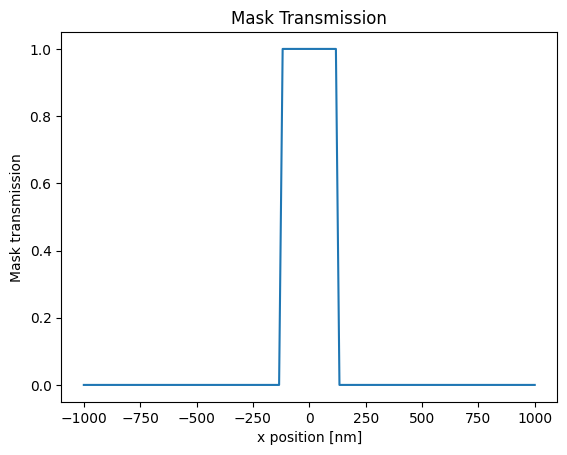

In [2]:
# Define the chromium dot size in nanometers
dot_size=250.
# Define the mask support (x support)
# Since we compute FT, better to chose a 2^n number of points
x_support=np.linspace(-1000.,1000.,128)
# Compute the pixel size in nanometers
dx=2000./128
# Define the mask, 1 for glass, 0 for chromium
mask=[1 if np.abs(x)<dot_size/2 else 0 for x in x_support]
# Plot
plt.title('Mask Transmission')
plt.plot(x_support, mask)
plt.xlabel('x position [nm]')
plt.ylabel('Mask transmission')
plt.show()

From there we compute **the Fourier Transform** of the mask.  
With numeric Fourier Transform one has to use the shift function to recenter the low frequency at the center for both spectrum and support. With also compute the analytic Fourier Transform of the mask: the Fourier Transform of a hole is a sinc function <font color=red>(Careful for normalisation, do not forget pixel size !)</font>.

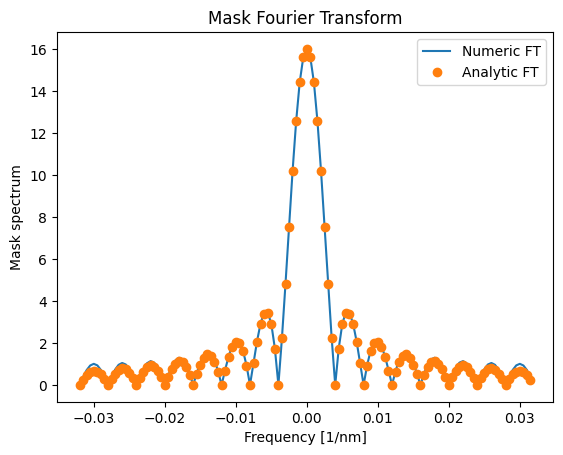

In [3]:
# Computation of the mask TF and its frequency support
mask_ft=np.fft.fftshift(np.fft.fft(mask))
# Do not forget the pixel size d when creating the frequency support
freq_support=np.fft.fftshift(np.fft.fftfreq(128,d=dx))
# Analytical Fourier Transform
mask_ana_ft=np.sinc(freq_support * dot_size)*dot_size/dx
# Plotting section
plt.title('Mask Fourier Transform')
plt.plot(freq_support,np.abs(mask_ft),label='Numeric FT')
plt.plot(freq_support,np.abs(mask_ana_ft),'o',label='Analytic FT')
plt.legend()
plt.xlabel('Frequency [1/nm]')
plt.ylabel('Mask spectrum')
plt.show()

### Source definition

The source **(S)** illuminates the mask **(M)** at different angles of incidence depending on its shape.
In lithography, the source is imaged by a collection lens **(Lc0)** at the entrance pupil **(P1)** of a another lens **(L1)**. The optical configuration used is called **Köhler illumination** and it is illustrated on the Figure below. This configuration ensures that a source point creates a set of plane waves uniformly illuminating the mask at a specific angle relative to the optical axis.

The source point on the optical axis (green point) creates a set of plane waves parallel to the optical axis. As the source points moves further from the optical axis the angle of incidence on the mask increases. The **Köhler illumination** ensures the uniform illumination of the mask: each point of the mask receives the same amount/directional light.

<img src="img/kohler.png" width="500" height="60" />
<h3 align="center">Köhler illumination principle : illumination of the mask</h3>

- **S**: source
- **Lc0**: collection lens 0
- **P1**: entrance pupil of L1
- **L1**: lens 1
- **M**: mask plane

Different shapes of source exist, the most simple one is the circular source, defined by its radius $\sigma$ that corresponds to the source **coherence**.
The source coherence in lithography shouldn't be mistaken with the general meaning of coherence in optics. In lithography, all source points are considered to be incoherent with each other from a spatial point of view. They do not have any phase relationship with each other. However the source is coherent from a temporal point of view since it is monochromatic. This consideration is the starting point of the Abbe theory : the overall image can be computed as the incoherent sum of each source point contribution.

Depending on the $\sigma$ value the source is said to be:
- Coherent if $\sigma=0$ : there is only one source point that is spatially coherent with itself.
- Incoherent if $\sigma=\inf$ : infinity of source points no spatial coherence.
- Partially coherent if $0<\sigma<\inf$

In pratice all sources used in lithography are partially coherent. But many textbooks use a coherent source to present fundamental properties of imaging before moving to partially coherent source.

If we consider a circular source of coherence $\sigma$ the image of the source through the optical system is also circular, it is a circle of radius $\frac{\sigma NA}{\lambda}$. In a photolithography tool the image of the source is projected at the entrance pupil of the projection lens **(P2)**.

<font color=red> The image of the source at the entrance pupil of the projection lens is called</font> **<font color=red>the effective source</font>**<font color=red>. It is not the Fourier Transform of the source ! It is an image of the source that is projected on the same plane as the mask spectrum. Thus, it is convenient to express it on a frequency support.</font>

The Figure below continues the ray tracing of the previous Figure in absence of a mask. The effective source is located at the P2 plane.

<img src="img/kohler_full.png" width="750" height="60" />
<h3 align="center">Köhler illumination principle : source effective at P2</h3>

- **Lc1**: collection lens 1
- **P2** : entrance pupil of L2, of radius NA
- **L2** : projection lens

At this point we have all the source points that contribute to the formation of the aerial image both in direct and frequency domain. 

The angle of incidence of the plane wave on the mask is **extremely important**. 
When illuminating an object with light parallel to the optical axis, the figure of diffraction of the object is formed at infinity (Fraunhofer diffraction regime) centered on optical axis. However, it is possible to bring this figure of diffraction to a finite distance by using a converging lens just after the object. This is exatcly what is happening in optical lithography. The source illuminates the mask and the **(Lc1)** lens brings back the infinite figure of diffraction at the entrance pupil of the projection lens. That is the reason why the effective source and the mask spectrum are expressed on the same plane (same frequency support).

If the optical system is supposed to be invariant by translation: an illumination that is not parallel to the optical axis results in a shift of the figure of diffraction without changing the amplitude of the diffraction orders (this assumption stands for low NA projection lens and the absence of polarisation). The frequency shift $\Delta f$ associated to an oblique illumination $\theta$ can be compute with this formula :
$$\Delta f=\frac{\sin(\theta)}{\lambda}$$

Since the source effective is expressed in frequency space, the frequency shift directly correspond to the frequency location of the source point.

*References*

- [Köhler, A. (1893). Ein neues Beleuchtungsverfahren für mikrophotographische Zwecke. Zeitschrift für wissenschaftliche Mikroskopie und für Mikroskopische Technik, 10(4), 433-440.](https://archive.org/details/cbarchive_41715_einneuesbeleuchtungsverfahrenf1893)

### Projection lens definition

The projection lens, as its name implies, projects the image of the mask on the substrate. We recall that the figure of diffraction of the mask is projected at the entrance pupil of the projection lens. Thanks to Fourier Optics properties of lens, the projection lens "computes" the inverse Fourier transform of the field at its entrance pupil before projecting it on its image plane. The dimension of the lens is not infinite : the entrance pupil corresponds to a circular aperture that blocks light that is too far from the optical axis. Consequently all diffraction orders from the figure of diffraction cannot be collected. This idea is illustrated on the Figure below, where only the zero and first diffraction order are collected (coherent illumination). Higher orders do not contribute to the image formation.

<img src="img/bragg.png" width="500" height="60" />
<h3 align="center">Collection of diffraction orders by the projection lens (coherent illumination here)</h3>
The projection lens acts as a low pass filter for the mask Fourier Transform. The low frequencies can go trough the lens aperture unperturbed and get recombined before being projected on the substrate.
However for frequencies larger than the projection lens cutoff frequency, the signal is lost. The cutoff frequency  $f_{cut}$ is defined as:
$$f_{cut}=\frac{\text{NA}}{\lambda}=\frac{nsin(\alpha)}{\lambda}$$

This frequency behavior is controlled by the projection lens numerical aperture : NA.
Mathematically, the effect of the projection lens is described as a circular transfert function as follows:


$$
\tilde{H}(f,g)=\text{circ}\left(\frac{\sqrt{f^2+g^2}}{\frac{\text{NA}}{\lambda}}\right) = \left\{
    \begin{array}{ll}
        1 & \mbox{if } \sqrt{f^2+g^2}<\frac{\text{NA}}{\lambda} \\
        0 & \mbox{otherwise}
    \end{array}
\right.
$$

Now that all functions are defined we can describe the Abbe and Hopkins formulations:

### Abbe's formulation of imaging
Historically, the first implementation of the imaging equation was proposed by Abbe. With **the Abbe's formulation**, also called *source point integration*, the aerial image is the result of the incoherent sum of each source points contribution to the overall image. The equation can be rewritten as follows:

$$I^{ABBE}(x,y)=\iint_{\infty}^{-\infty} \tilde{J}(f,g)\left[\left|\iint_{\infty}^{-\infty}\tilde{H}(f+f',g+g')\tilde{O}(f',g')e^{-2i\pi[f'x+g'y]}df'dg'\right| ^2\right]dfdg$$
The integral boundaries can be simplified considering the finite extension of the source, it is non zero for $(f,g) \in S$ :
$$I^{ABBE}(x,y)=\iint_{(f, g) \in S} \tilde{J}(f,g)\left[\left|\iint_{\infty}^{-\infty}\tilde{H}(f+f',g+g')\tilde{O}(f',g')e^{-2i\pi[f'x+g'y]}df'dg'\right| ^2\right]dfdg$$
So what's happening there ? If we look at the term between square brackets, we can see that it corresponds to an inverse Fourier Transform of a product between $\tilde{H}(f+f',g+g')$ and $\tilde{O}(f',g')$. If you remember we said that for oblique illumination the figure of diffraction of the mask is shifted at the entrance pupil of the projection lens. From a numerical point of view it is easier to consider a shift of the projection lens pupil rather than shifting the mask Fourier Transform, the result is **exactly the same**.

When considering a source point at $(f, g)$ the pupil is shifted accordingly at $(f+f',g+g')$. So depending on the pupil transfer function position, different portion of the mask diffraction pattern will be gathered.

The Abbe's formulation is especially useful when illumination is changed such as source mask optimisation. However, most of the time, the source is fixed, and only the mask changes. For this situation the Hopkins's method is preferrable.

*References*
- [Abbe, E. (1873). Beiträge zur Theorie des Mikroskops und der mikroskopischen Wahrnehmung. Archiv für mikroskopische Anatomie, 9(1), 413-468](https://link.springer.com/article/10.1007/BF02956173)


### Hopkins formulation of imaging
The second implementation is **the Hopkins formulation** that was proposed 80 years later. By changing the order of integration the source and the mask contribution are splitted appart. The imaging equation is rewritten as follows:

$$I^{HOPKINS}(x,y)=\iiiint_{\infty}^{-\infty}TCC(f',g';f'',g'')\tilde{O}(f',g')\tilde{O}^{*}(f'',g'')e^{-2i\pi[(f'-f'')x+(g'-g'')y]}df'dg'df''dg''$$

This notation introduces the *Transmission Cross Coefficients (TCC)* that are defined as :
$$TCC(f',g';f'',g'')=\iint_{\infty}^{-\infty}\tilde{J}(f,g)\tilde{H}(f+f',g+g')\tilde{H}^*(f+f'',g+g'')dfdg$$

The Hopkins formulation is more difficult to understand. Hopefully the TCC integral compuattaion can be represented graphically.

The three function in the integral are represented as circle (circular source and circular pupils) on the Figure below, the TCC coefficient is non zero when the 3 functions overlap (blue region).

Computing the TCC results in evaluating the integral for all possible pupil $\tilde{H}$ and $\tilde{H}^*$ positions while maintaining the source $\tilde{J}$ fixed. The integral is computed at the entrance pupil of the projection lens thus in frequency space.
<img src="img/tcc_visual_computation.png" width="500" />
<h3 align="center">Representation of the TCC integral computation</h3>

Once the TCC are computed they do not need to be recomputed if the mask changes. For that reason, the Hopkink's formulation is used in optical proximity correction algorithm, a discpline in which engineer optimise a photomask at fixed illumination to improve the pattern transfer into the resist.

*References*

- [Hopkins, H. H. (1953). On the diffraction theory of optical images. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 217(1130)](https://doi.org/10.1098/rspa.1953.0071)


### Numeric implementation for Abbe method

The algorithm corresponding to the Abbe method for aerial image is constructed as follows:


1. Computation of the effective source based on the frequency support of the mask Fourier Transform.
2. Loop over all effective source points (reminder : each source point is a frequency).
3. For the current source point, a shifted frequency support is generated.
4. The shifted frequency support is used to create the shifted transfer function of the projection lens.
5. The Fourier Transform of the mask is multiplied by the shifted transfer function of the projection lens.
6. The inverse Fourier Transform of step 5 is computed and its squared modulus is added to the overall aerial image.
7. Repeat step 3 to 6 for all source points.

The code for a 1D mask is described below:

In [1165]:
def compute_abbe(sigma, NA, wavelength, mask_ft, frq, make_plots=False):
    # Define the effective source points of the circular source
    source_points=[f for f in frq if np.abs(f)<=sigma*NA/wavelength]
    # Initialisation of the aerial image as single precision
    aerial_image=np.zeros_like(mask_ft,dtype='float32')
    # Compute all source points contribution to the aerial image
    for freq_src in source_points:
        # Shift of the frequency support relative to the current source point frequency
        freq_msk_shft = [(f - freq_src) for f in frq]
        # Shifted transfer function of the projection lens.
        pupil_shifted = [1 if np.abs(f) <= NA/wavelength else 0 for f in freq_msk_shft]
        # The shifted transfer function of the projection lens is applied to the mask spectrum
        mask_lpf = np.multiply(mask_ft, pupil_shifted)
        # Add the contribution of the current src point to the overall aerial image
        aerial_image += np.abs(np.fft.ifft(mask_lpf)) ** 2
    # Normalisation with number of source points
    aerial_image /= len(source_points)
    # Plotting
    if make_plots:
        fig=plt.figure()
        plt.title(f'Aerial Image - {len(source_points)} source points')
        plt.plot(x_support,aerial_image)
        plt.xlabel('x position [nm]')
        plt.ylabel('Intensity [au]')
        plt.show()
    else:
        return aerial_image

The Figure below let you change different parameters to see the impact on the aerial image.<br>
<font color=red> <b>Unfortunately interactive widget do no run on GitHub please download and run the Jupyter File on your local machine to use this feature.</b></font>

In [1166]:
#Uncomment to use interactive mode
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
interact(compute_abbe, sigma=(0.0,1.0,0.01),NA=(0.2,0.6,0.01), wavelength=[('436nm', 436), ('365nm', 365),('248nm', 248), ('193nm', 193)],mask_ft=fixed(mask_ft),frq=fixed(freq_support),make_plots=fixed(True));

interactive(children=(FloatSlider(value=0.5, description='sigma', max=1.0, step=0.01), FloatSlider(value=0.4, …

In case interactive plot does not show, we plot below the result for an i-line stepper.

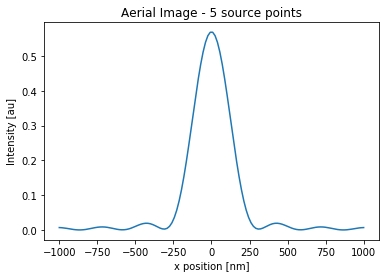

In [1167]:
compute_abbe(sigma=0.7,NA=0.57,wavelength=365.,mask_ft=mask_ft,frq=freq_support,make_plots=True)

Another common benchmark is to compute the aerial image of a knife edge also called Heavyside function.

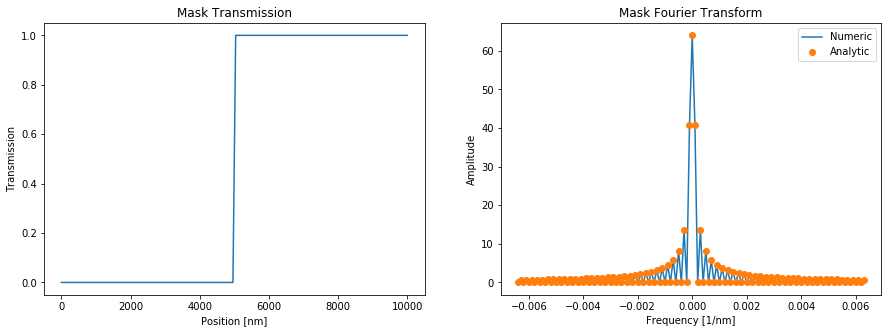

In [1168]:
# Heavyside mask creation
n_pts=128
x_suppt_heavyside=np.linspace(0,10000.,n_pts)
mask_heavyside=[1 if x>=5000 else 0 for x in x_suppt_heavyside]
# Pixel size in nanometers
dx_heavyside=10000./n_pts
# Computation of the mask TF and its frequency support
mask_ft_heavyside=np.fft.fftshift(np.fft.fft(mask_heavyside))
freq_support_heavyside=np.fft.fftshift(np.fft.fftfreq(n_pts,d=dx_heavyside))
# Analytical Fourier Transform first shift, then TF
mask_ana_ft_heavyside=np.exp(-1j * 2. * np.pi * freq_support_heavyside * 2500)
mask_ana_ft_heavyside*=np.sinc(freq_support_heavyside * 5000.)*5000./dx_heavyside
# Plotting section
fif,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Mask Transmission')
ax[0].plot(x_suppt_heavyside,mask_heavyside)
ax[0].set_xlabel('Position [nm]')
ax[0].set_ylabel('Transmission')
# FT plot
ax[1].set_title('Mask Fourier Transform')
ax[1].plot(freq_support_heavyside,np.abs(mask_ft_heavyside),label='Numeric')
ax[1].plot(freq_support_heavyside,np.abs(mask_ana_ft_heavyside),'o',label='Analytic')
ax[1].set_xlabel('Frequency [1/nm]')
ax[1].set_ylabel('Amplitude')
ax[1].legend()
plt.show()

Let's compute the aerial image for different source coherence to show the impact of this parameter:

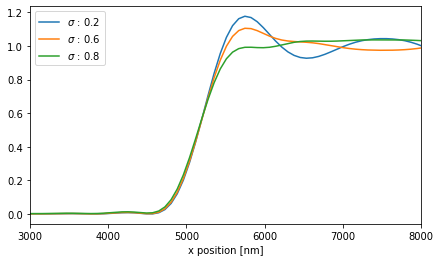

In [1169]:
plt.figure(figsize=(7,4))
# Loop over different coherence values
for sigma in [0.2, 0.6, 0.8]:
    aerial_image_heavyside=compute_abbe(sigma=sigma,NA=0.28,wavelength=436.,mask_ft=mask_ft_heavyside,frq=freq_support_heavyside)
    plt.plot(x_suppt_heavyside,aerial_image_heavyside,label=f'$\sigma$ : {sigma}')
plt.xlim(3000.,8000.)
plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.legend()
plt.show()

We can compare our model result with the plot of the original article:

- [O'Toole, M. M., & Neureuther, A. R. (1979). *Influence of partial coherence on projection printing. In Developments in Semiconductor Microlithography IV* (Vol. 174, pp. 22-27). International Society for Optics and Photonics.](https://spie.org/Publications/Proceedings/Paper/10.1117/12.957174)


<img src="img/neureuther_coherence_heavyside.PNG" width="500" />

### Numeric implementation for Hopkins method
<font color=red> <b>Make sure that the support for the mask definition is strictly positive for Hopkins formulation.</b></font>

The algorithm corresponding to the Hopkins method for aerial image is constructed as follow
1. The first step is to compute the TCC coefficients.
2. For all non zero TCC compute the equation of Hopkins equation
3. Normalise aerial image with aerial image for a clear mask (only quartz)

In [1170]:
# Initialisation of the TCC list
tcc_list=[]
def tcc_computation(sigma, NA, wavelength, freqs):
    # Function radius (= cutoff frequencies) 
    f_cut_src = sigma * NA / wavelength
    f_cut_pupil = NA / wavelength
    # Source creation
    y_src = [1 if np.abs(f) <= f_cut_src else 0 for f in freqs]
    # k factor definition
    k = 2 * np.pi / wavelength
    # Loop over diffractions orders for the first pupil
    for idx_m, f_m in enumerate(freqs):
        # The first pupil is created via a shifted frequency support
        freq_pup_1 = [f - f_m for f in freqs]
        y_pup1 = [1 if np.abs(f) <= f_cut_pupil else 0 for f in freq_pup_1]
        # Loop over diffractions orders for the second pupil
        for idx_n, f_n in enumerate(freqs):
            # The second pupil is also created via a shifted frequency support
            freq_pup_2 = [f - f_n for f in freqs]
            y_pup2 = [1 if np.abs(f) <= f_cut_pupil else 0 for f in freq_pup_2]
            # Integral computation of the overlapping three functions
            product = np.multiply(y_src, np.multiply(y_pup1, y_pup2))
            #The overlapping area is computed with a trapezoidal integration
            area = np.trapz(product, freqs)
            # If the TCC coefficient is non zero it is added to the TCC list
            if np.abs(area) > 0:
                tcc_list.append((idx_m, idx_n, f_m, f_n, area))

    print('Number of TCC :', len(tcc_list))

In [1171]:
tcc_computation(0.4, 0.28, 436.,freq_support_heavyside)

Number of TCC : 269


Once the TCC are calculated the Hopkins implementation is straightforward:

In [1172]:
def compute_hopkins(mask_ft, freq_suppt, x_suppt, tcc_list, pixel_size):
        # Compute the mask Fourier transform conjugate
        mask_ft_conj = np.conjugate(mask_ft)
        # Instanciate aerial image
        aerial_image = np.zeros_like(mask_ft)
        # Loop over all TCC coefficients
        for idx_m, idx_n, f_m, f_n, tcc_mn in tcc_list:
            exp_term = np.exp(1j * 2 * np.pi * (f_m - f_n) * (x_suppt-pixel_size/2))
            aerial_image += tcc_mn * mask_ft[idx_m] * mask_ft_conj[idx_n] * exp_term
        return np.real(aerial_image)

We propose to compute the aerial image of the Heavyside mask that has already be defined previously.

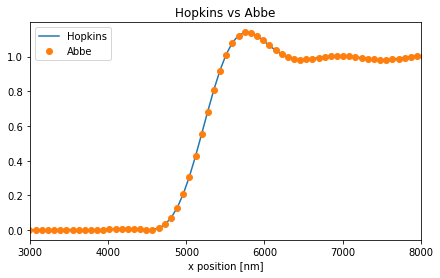

In [1173]:
# First we compute the aerial image of a clear mask
mask_quartz=np.ones_like(mask_ft_heavyside)
aerial_image_norm=compute_hopkins(mask_ft=np.fft.fftshift(np.fft.fft(mask_quartz)),
                                  freq_suppt=freq_support_heavyside,
                                  x_suppt=x_suppt_heavyside,
                                  tcc_list=tcc_list,pixel_size=dx_heavyside)
# Compute aerial image of the heavyside mask
aerial_image_hopkins=compute_hopkins(mask_ft=mask_ft_heavyside, freq_suppt=freq_support_heavyside,
                                     x_suppt=x_suppt_heavyside, tcc_list=tcc_list,pixel_size=dx_heavyside)
# Recompute aerial image with Abbe to compare both models
aerial_image_abbe=compute_abbe(sigma=0.4,NA=0.28,wavelength=436.,mask_ft=mask_ft_heavyside,frq=freq_support_heavyside)
# Plot Hopkins and Abbe aerial image on same plot
plt.figure(figsize=(7,4))
plt.title('Hopkins vs Abbe')
plt.plot(x_suppt_heavyside,aerial_image_hopkins/aerial_image_norm,label='Hopkins')
plt.plot(x_suppt_heavyside,aerial_image_abbe,'o',label='Abbe')
plt.xlim(3000.,8000.)
plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.legend()
plt.show()

The result is almost exactly the same, there is a little shift that can be accounted on the trapezoidal integration method used for the TCC computation.

## Exposition Model

The next step in simulating the lithographic process is the exposition of the resist. During lithography the resist is exposed to a certain energy : **the dose**. In lithography the surfacic power of the source is fixed, and expressed in W/m²:
$$\text{lamp power}=S^P [\text{W}/m²]$$
The **dose** is expressed as a surfacic energy, it corresponds to the time of exposition times the lamp power:
$$ \text{Dose}=S^P \cdot t^{expo} [\text{J/m²}]$$
The mask modulates the incident energy received by the resist. The local intensity received by the resist is the dose times the aerial image value at this particular point. The top surface of the resist receives the following energy:
$$ \text{energy at resist surface point x}=Dose \cdot I(x) $$
The energy received at the top of the resist propagates inside the resist (*z* axis) and triggers photochemical reactions.
The most simple model to simulate the light absorption through the photoresist is a Beer Lambert absorption.
$$I(x,z)=I(x)e^{-\alpha z}$$
- $I(x,z)$ is called the **bulk image** it is the light intensity distribution inside the photoresist.
- $\alpha$ is the absorption coefficient of the resist it can be expressed with two equations :
$$\alpha=A\cdot m(x,z)+B=\frac{4\pi \kappa}{\lambda}$$
- A and B are Dill's coefficient of the resist, usually supplied by the resist manufacturer. There is also a C coefficient.
- $\kappa$ is the extinction coefficient of the resist.
- $\lambda$ is the wavelength.
The code below presents the computation of light absorption through a resist stack of thickness 1µm. The mask is a single hole centered on origin computed at the beginning of the notebook.

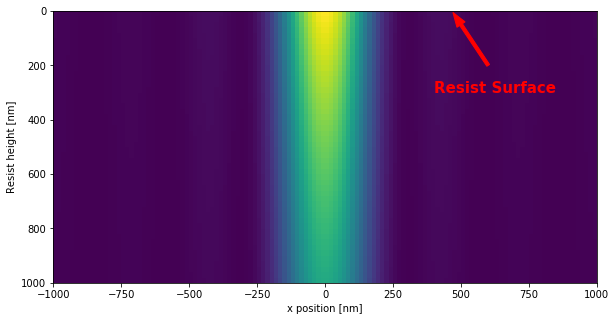

In [1174]:
# Choose an alpha coefficient
alpha= 0.0005
# Compute the aerial image
aerial_image=compute_abbe(sigma=0.7,NA=0.57,wavelength=365.,mask_ft=mask_ft,frq=freq_support,make_plots=False)
# Create a meshgrid corresponding to the resist coordinates in x and z direction
nz=50
thickness=1000.
dz=thickness/nz
z=np.linspace(0,thickness,nz)
X,Z=np.meshgrid(x_support,z)
# Instanciate bulk image, the aerial image is stacked with itself nz times.
aerial_image=np.stack([aerial_image for _ in range(nz)])
bulk_ini=np.stack(aerial_image,0)
# Apply beer Lambert absorption
bulk_img=bulk_ini*np.exp(-alpha*Z)
# Plotting section
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.imshow(bulk_img,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax.arrow(600,200,-100,-150,color='r',width=12)
ax.text(400,300,'Resist Surface',color='r',weight='bold',size=15)
ax.set_xlabel('x position [nm]')
ax.set_ylabel('Resist height [nm]')
plt.show()

Up to now, we only discussed the light intensity inside the photoresist. Of course this energy will affect the resist chemical properties. An i-line photoresist is composed of 3 components:
- A polymer slightly soluble into a developement solution.
- A photoacid coumpound (PAC) that is fixed to the polymer and totally prevent its dissolution.
- A solvant that binds the polymer and PAC together.

During exposition, light will decompose the PAC, thus increasing the polymer solubility to the developer.
When simulating resist exposition, it is the PAC concentration that is going to be of interest.
The normalised PAC concentration inside the photoresist is called **latent image**. It is defined as $m$. At the beginning of exposition the PAC concentration is set to 1 everywhere in the photoresist. The evolution of the PAC concentration is related to the bulk image by the Dill's equations (See Reference below):

$$\frac{\partial m(x,z,t)}{\partial t}=-C\cdot I(x,z,t) \cdot m(x,z,t) $$
$$\frac{\partial I(x,z,t)}{\partial z}=-\left[A\cdot m(x,z,t)+B\right]I(x,z,t) $$

- A, B and C are the photoresist Dill's coefficient.

Without any assumption the equations cannot be solved simustaneously. The trick is to decompose the total exposition time $t_{expo}$ into small time steps $\Delta t$. With this assumption the partial equation can be solved and the bulk image and latent image computed alternatively with :

$$m(x,z,t+\Delta t)=m(x,z,t)e^{-C\cdot I(x,z,t)\Delta t}$$
$$I(x,z,t+\Delta t)=I(x,z;\alpha=A\cdot m(x,z,t)+B)=I(x)e^{-[A\cdot m(x,z,t)+B]z}$$

*Reference*
- [Dill, F. H., Hornberger, W. P., Hauge, P. S., & Shaw, J. M. (1975). Characterization of positive photoresist. IEEE Transactions on electron devices, 22(7), 445-452.](https://ieeexplore.ieee.org/abstract/document/1477994)

The numerical scheme for the simulation of exposition is the following:
0. Compute the time step $\Delta t$
1. $t=0 \mapsto$  Compute initial bulk image $I(x,z,t=0)$ and initial latent image $m(x,z,t=0)=1$

2. $t=\Delta t\mapsto$  Update latent image: $m(x,z,t=\Delta t)=m(x,z,t=0)e^{-C\cdot I(x,z,t=0)\Delta t}=e^{-C\cdot I(x,z,t=0)\Delta t}$

3. $t=\Delta t\mapsto$ Update alpha: $\alpha=A\cdot m(x,z,t=\Delta t)+B$
4. $t=\Delta t\mapsto$ Update bulk image: $I(x,z,t+\Delta t)=I(x)e^{-\alpha z}$
5. $t_{tot}= \Delta t$.
6. $t=2\Delta t\mapsto$  Update latent image: $m(x,z,t=2\Delta t)=m(x,z,t=\Delta t)e^{-C\cdot I(x,z,t=\Delta t)\Delta t}$
7. $t=2\Delta t\mapsto$ Update alpha: $\alpha=A\cdot m(x,z,t=2\Delta t)+B$
8. $t=2\Delta t\mapsto$ Update bulk image: $I(x,z,t+\Delta t)=I(x)e^{-\alpha z}$
9. $t_{tot}= 2\Delta t$.
10. Repeat until $t_{tot}= t_{expo}$.

Implementation of this code is presented below:

In [1175]:
# Initialise latent image
lat_img=np.ones_like(bulk_img)
# Instanciate resist parameters A in [1/nm], A in [1/nm] and C in [m²/J]
dill_a=0.00075
dill_b=0.00005
dill_c=0.0025

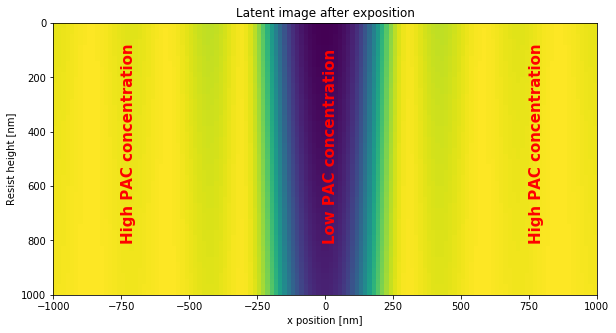

In [1176]:
# Typical lamp power in W/m²
lamp_power=30000
# Dose in J/m²
dose=2000
# Exposure time in s
t_tot=dose/lamp_power
n_steps=50
# Discretize exposure time
time_step=t_tot/n_steps
# Loop to compute exposition
for n in range(n_steps):
    # Latent image update
    lat_img*=np.exp(-dill_c*bulk_img*time_step*lamp_power)
    # Absorption coefficient update
    alpha=dill_a*lat_img+dill_b
    # Bulk image update
    bulk_img=bulk_ini*np.exp(-alpha*Z)
    
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.set_title('Latent image after exposition')
ax.imshow(lat_img,extent=[np.min(x_support) , np.max(x_support), thickness ,0])
ax.text(-7.5,800,'Low PAC concentration',color='r',weight='bold',size=15,rotation=90)
ax.text(-750,800,'High PAC concentration',color='r',weight='bold',size=15,rotation=90)
ax.text(750,800,'High PAC concentration',color='r',weight='bold',size=15,rotation=90)
ax.set_xlabel('x position [nm]')
ax.set_ylabel('Resist height [nm]')
plt.show()

## Development model
Once the latent image at the end of exposition is known the next step is to compute the developement process.
Depending on dose received by the resist, the latent image dictates whether the resist is developed or not. For positive resist exposed areas are removed while un-exposed area are left.
- The simplest way to simulate developement is using a **threshold developement model**. Depending on a threshold value $m_{th}$ for the latent image, the resist is considered to be developed or not. For example if the threshold
 is set to 0.4, every point of the resist with latent image value smaller than 0.4 will be developed. All point with latent image bigger than 0.4 are not developped. Numerically this methods is simply a contour finding algorithm.
For complex patterning, this approach is not precise enough.

During developement the photoresist is in contact with a liquid developer for a time $t_{dev}$. The developer "eats up" the resist as time pass. From a mathematical point of view, the photoresist developement can be modelled by an eikonal equation:

$$|\nabla T(x,y,z)|R(x,y,z)=1$$

Where $T(x,y,z)$ is the time needed for the developer to reach the point located at $(x,y,z)$ and $R(x,y,z)$ is the developer speed inside the photoresist in nm/s, also called development rate function. Multiple development rate functions exist (Mack 4 parameters, Mack 5 parameters, Dill function, LPM...)

As example, we will use the 4-parameters Mack development rate function:

$$R(x,y,z)=r_{max}\frac{(a+1)(1-m(x,y,z))^n}{a+(1-m(x,y,z))^n}+r_{min}$$
Where $a$ is expressed as:
$$a=\frac{n+1}{n-1}(1-m_{th})^n$$
- $n$ is the reaction order
- $m_{th}$ is the threshold concentration
- $r_{min}$ is the minimum development rate [nm/s]
- $r_{max}$ is the maximum development rate [nm/s]

*References*
- [Mack, C. A. (1987). Development of positive photoresists. Journal of the Electrochemical Society, 134(1), 148.](https://iopscience.iop.org/article/10.1149/1.2100396/meta)


In [1177]:
# This function computes the developement rate according to the 4 parameters model from Mack.
def Mack_Developement_Rate(latent_img, m_th, r_min, r_max, n):
    a_mack = (1 - m_th) ** n
    a_mack *= (n + 1) / (n - 1)
    dev_rate = (a_mack + 1) * (1 - latent_img) ** n
    dev_rate /= a_mack + (1 - latent_img) ** n
    dev_rate *= r_max
    dev_rate += r_min
    dev_rate = np.clip(dev_rate, r_min, r_max)
    return dev_rate
# Computation of the development rate with typical parameters
cur_dev_rate=Mack_Developement_Rate(latent_img=lat_img, m_th=0.01, r_min=0.8, r_max=50, n=2)

Once the development rate is computed, the developer speed inside the resist is known everywhere. 
The substrate is developed during a certain amount of time: $t_{dev}$. The last part of the development simulation is to find the developer front position at this moment.

The final resist profile corresponds to the envelop $T(x,y,z)=t_{dev}$

$$|\nabla T(x,y,z)|=\frac{1}{R(x,y,z)}$$
$$\sqrt{\left(\frac{\partial T}{\partial x}\right)^2+\left(\frac{\partial T}{\partial y}\right)^2+\left(\frac{\partial T}{\partial z}\right)^2}=\frac{1}{R(x,y,z)}$$

It is possible to consider that the development path is strictly vertical:
$$\frac{dT}{dz}=\frac{1}{R(x,y,z)}$$
In that case the computation of $T(x,y,z)$ is straightforward:
$$T(x,y,z)=\int_{0}^{d}\frac{dz}{R(x,y,z)}$$

The integral method is cmputed below. The red contour corresponds to the resist profile at  $t_{dev}=60s$.

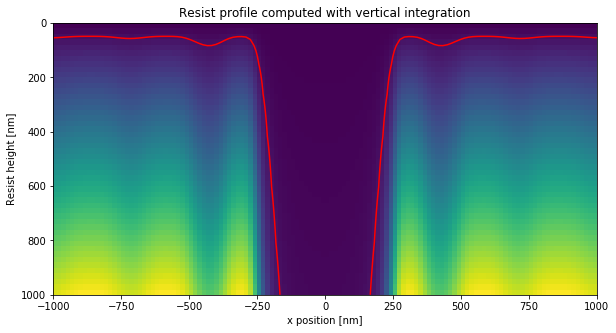

In [1178]:
from scipy.integrate import cumtrapz
time_resist_z = cumtrapz(1. / cur_dev_rate, dx=dz, axis=0,initial=0)
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.set_title('Resist profile computed with vertical integration')
ax.imshow(time_resist_z, extent=[np.min(x_support) , np.max(x_support), thickness ,0])
ax.contour(X,Z,time_resist_z,levels=[60,],colors='r')
ax.set_xlabel('x position [nm]')
ax.set_ylabel('Resist height [nm]')
plt.show()

In the general case the development path is not strictly vertical. In this situation, the use of **fast marching algorithm** is required. The fast marching algorithm is an iterative solver for the eikonal equation. It requires an oriented field (for the propgation direction) and a speed field. The algorithm computes the time required for the speed field to reach each point in the field. This approach was initially proposed by Sethian, see reference:

*Reference*
- [Sethian, J. A. (1996, June). Fast-marching level-set methods for three-dimensional photolithography development. In Optical Microlithography IX (Vol. 2726, pp. 262-272). International Society for Optics and Photonics.](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/2726/0000/Fast-marching-level-set-methods-for-three-dimensional-photolithography-development/10.1117/12.240962.short?SSO=1)

Computation with fast marching algorithm is shown below:

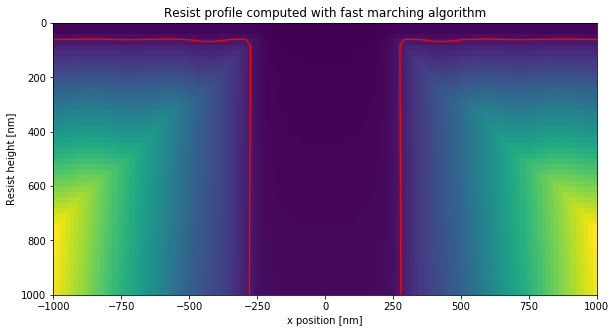

In [1179]:
import skfmm
# Fast Marching require a negative frontier to compute travel time
# We add this frontier artifically (it will be removed later)
neg_layer = -1 * np.ones_like(lat_img[0, :])
lat_img = np.vstack((lat_img, neg_layer))
cur_dev_rate = np.vstack((neg_layer, cur_dev_rate))
# Compute fast marching (! the algorithm flips the array along axis 0)
time_resist_fmm = skfmm.travel_time(lat_img, cur_dev_rate, dx=[dz, dx],periodic=[False,True])
# Remove artificial negative layer
time_resist_fmm=time_resist_fmm[1:,:]
# Flip array back to normal
time_resist_fmm=np.rot90(time_resist_fmm,k=2)
# Plotting
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.set_title('Resist profile computed with fast marching algorithm')
ax.imshow(time_resist_fmm, extent=[np.min(x_support) , np.max(x_support), thickness ,0])
ax.contour(X,Z,time_resist_fmm,levels=[60,],colors='r')
ax.set_xlabel('x position [nm]')
ax.set_ylabel('Resist height [nm]')
plt.show()

Next we plot the two resist profiles on the same graph to highlight the differences:

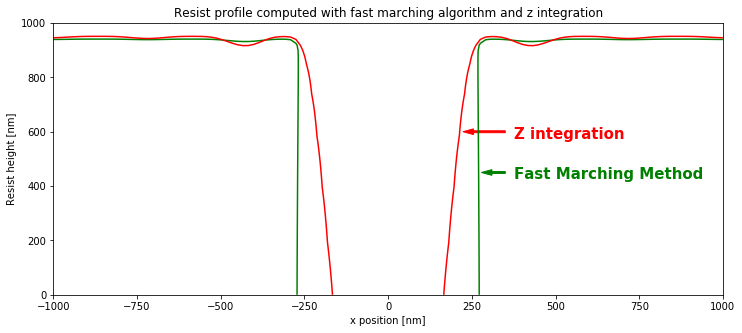

In [1180]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.set_title('Resist profile computed with fast marching algorithm and z integration')
ax.contour(X,Z,time_resist[::-1,:],levels=[60,],colors='g')
ax.arrow(350,450,-40,0,color='g',width=7)
ax.text(375, 425, 'Fast Marching Method',color='g',weight='bold',size=15)
ax.contour(X,Z,time_resist_z[::-1,:],levels=[60,],colors='r')
ax.arrow(350, 600,-95,0,color='r',width=7)
ax.text(375,575, 'Z integration',color='r',weight='bold',size=15)
ax.set_xlabel('x position [nm]')
ax.set_ylabel('Resist height [nm]')
plt.show()

# Conlusion

In this Notebook we have seen:

- The imaging equation and how to simulate the aerial image with Abbe and Hopkins formulation
- The simulation of exposition.
- Different approachs for the simulation of development.

In the next Notebook we will adress:

- Aberrations of the projection lens with the case of defocus.
- Application of the defocus to the propagation of aerial image in the resist.
- Effect of standing waves and how to simulate them.

In [4]:
# Code to automatically center the matplotlib figures
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Author credentials:

**Pierre Chevalier**, PhD candidate.
pierrechevalier63@gmail.com

<a href="https://www.linkedin.com/in/pierre-chevalier/" target="_blank"> 
<img src="img/linkedIn.png" width=75 > 
</a> <a href="https://scholar.google.com/citations?user=J7pBOkoAAAAJ&hl=fr&oi=sra" target="_blank"> 
<img src="img/Google_Scholar_logo_2015.png" width=175 > 
</a> 